# SpaceX Falcon 9 First Stage Landing Prediction

Paolo Furlanetto Ferrari

October 2023


## Part IV: Machine Learning Models

The previous three Parts consisted of extracting, transformin and visualizing the Falcon 9 data. In this part, we use the previously generated data to train several machine learning models. Our goal is to learn what is the likely outcome of a mission given all its details.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

First, we import the dataframe with the one-hot encoding generated in Part I.

In [3]:
X = pd.read_csv("one_hot_df.csv")
X.head(2)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False


We then split the predictors $X$ from the reponse variable $Y$ by extracting the Class column and then dropping it from the dataframe.

In [4]:
Y = X['Class'].to_numpy()
X = X.drop(["Class"], axis=1)

To facilitate fitting, we standardize the $X$ variables

In [5]:
transform = preprocessing.StandardScaler()
transform.fit(X)
X = transform.transform(X)
X

array([[-1.71291154,  0.        , -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.67441914, -1.18972425, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.63592675, -1.15742336, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [ 1.63592675,  2.01380177,  3.49060516, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [ 1.67441914,  2.01380177,  1.00389436, ..., -0.21566555,
         5.38516481, -0.10599979],
       [ 1.71291154, -0.51905572, -0.65391284, ..., -0.21566555,
        -0.18569534,  9.43398113]])

We then split the data 80/20 between train and test sets

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [7]:
Y_test.shape

(18,)

When we evaluate the performance of the models in the test set, we will make use of the following function, which plots the confusion matrix given the true labels $Y$ and precdicted labels $\hat{Y}$

In [8]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

### Logistic Regression

We start with the logit model with Ridge regularization. To compute the ridge paramater $\alpha$, we apply a 10-fold cross-validation (CV) using the train set. The goal of the CV is to choose between $\alpha = 1, 10$ or $100$ by selecting the value yielding the highest average accuracy on the 10 folds.

In [9]:
parameters = {"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']} #l2 for ridge regularization
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr,parameters,cv=10)
logreg_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [10]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


Check the accuracy of the best model in the test set:

In [11]:
logreg_cv.score(X_test,Y_test)

0.8333333333333334

Finally, check the confusion matrix on the test set:

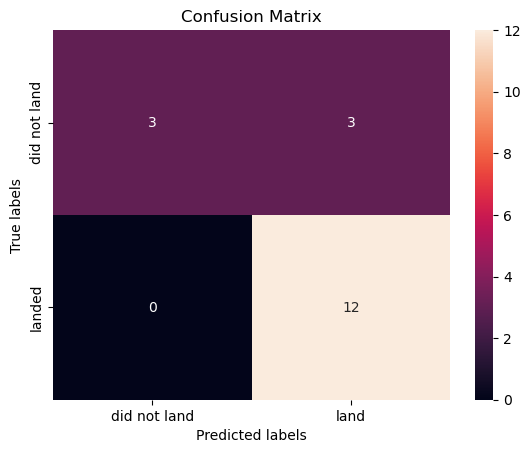

In [12]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Support Vector Machine

Again, we use a 10-fold CV to select between different models. Here we apply Suport Vector Machine with different kernels and different. The GridSearchCV will perform a search for different kernels and different scaling paramaters for each kernel. The model with highest average accuracy on the train set will be chosen.

In [13]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm,parameters,cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [14]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


Check accuracy and the confusion matrix of the best model for the test set:

In [15]:
svm_cv.score(X_test,Y_test)

0.8333333333333334

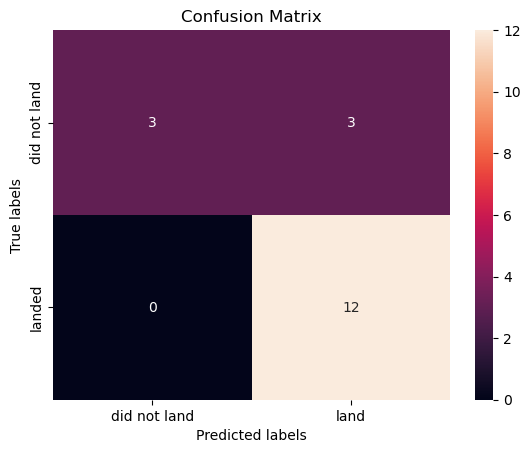

In [16]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Decision Tree

The third class of models we test is the Decision Tree family. The 10-fold CV will evaluate trees with different hyperparameters, such as the split criterion (gini or entropy), the splitter (absolute best or best random), maximum tree depth, maximum features for each split, minimum number of samples on the leaves and minimum number of samples for a split to happen.

In [17]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [18]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.8714285714285713


In [19]:
tree_cv.score(X_test, Y_test)

0.7222222222222222

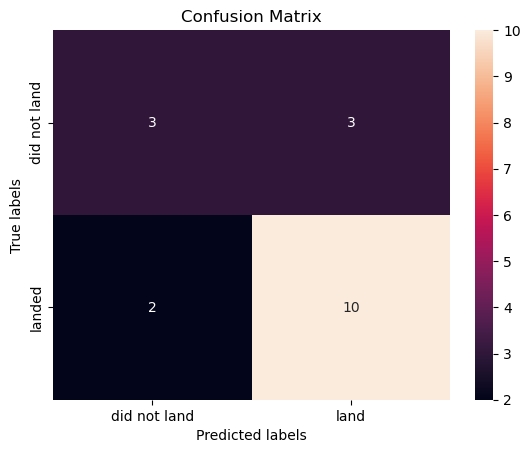

In [20]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### K-Nearest Neighbors

The final class of models is the k-NN model with different $k$ from 1 to 10 as well as different search algorithms for the neighbors.

In [21]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN,parameters,cv=10)
knn_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [22]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [23]:
knn_cv.score(X_test,Y_test)

0.7777777777777778

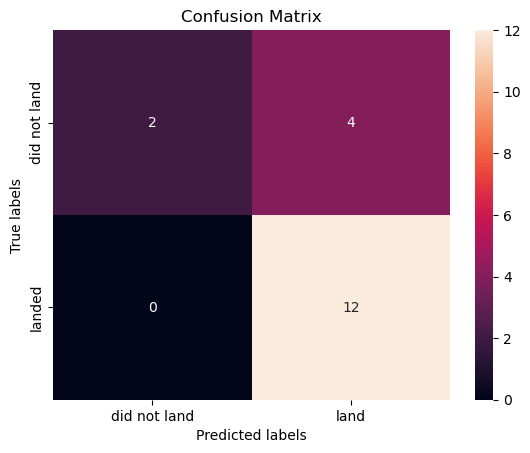

In [24]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Comparison between Models

Finally, we compare the best models from each family and compare the results here. 

Text(0.5, 0, 'Model')

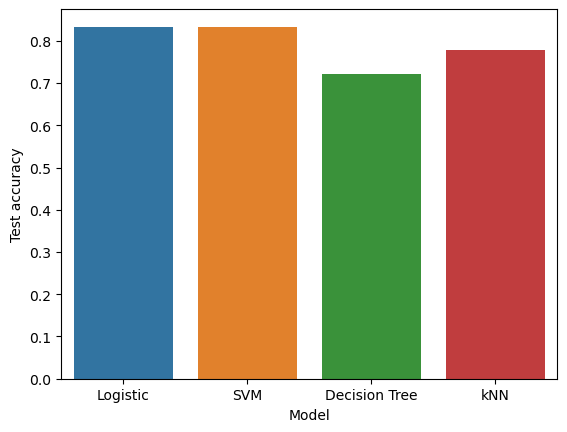

In [25]:
sns.barplot(x=['Logistic', 'SVM', 'Decision Tree', 'kNN'], y=[logreg_cv.score(X_test,Y_test),
                                                                svm_cv.score(X_test,Y_test),
                                                                tree_cv.score(X_test, Y_test),
                                                                knn_cv.score(X_test,Y_test)])
plt.ylabel('Test accuracy')
plt.xlabel('Model')

It is clear that both Logistic and SVM are the best models, with an accuracy of 83.3% on the test set.